# Fluorescence intensity detection and identification system

Using OpenCV to detect fluorescence intensity which emulates SYBR Green fluorescence from multiple color jpeg images. Data is parsed from HTTP POST requests by ESP32-CAM with OV2640 sensor.

In [2]:
# import os
# os.environ['QT_QPA_PLATFORM'] = 'xcb'

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## 1. Test camera noise by getting average pixel value of a blank image

Get image from box_wb_off

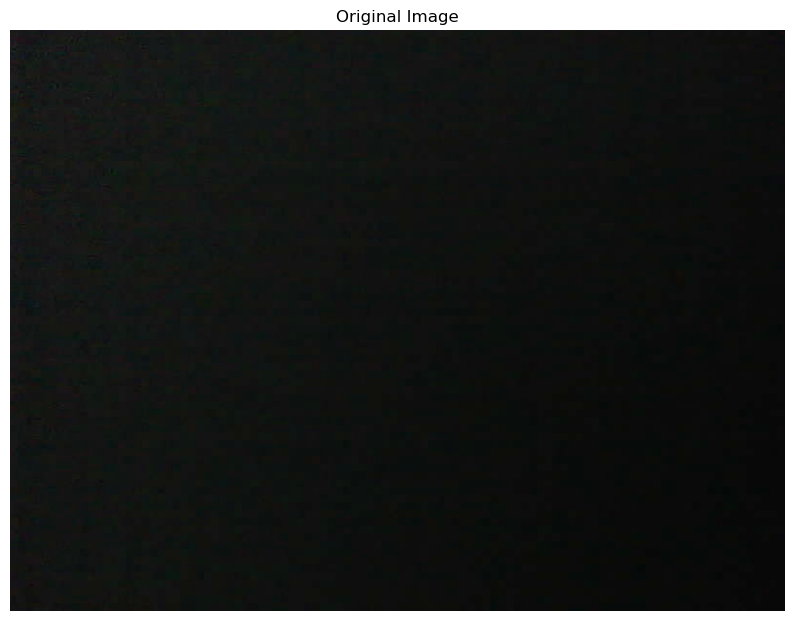

In [ ]:
img = cv.imread('from-esp/box_wb_off/image_20250628_101012_080.jpg')
gray1 = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.show()

# plt.figure(figsize=(10, 8))
# plt.imshow(gray1, cmap='gray')
# plt.title('Grayscale Image')
# plt.axis('off')
# plt.show()

Average all pixels in the image and print out the 8-bit value.

Overall average pixel value: 16.66

Image dimensions: 800 x 600
Section size: 200 x 200

Noise analysis:
Min section average: 9.78
Max section average: 23.88
Standard deviation across sections: 4.09


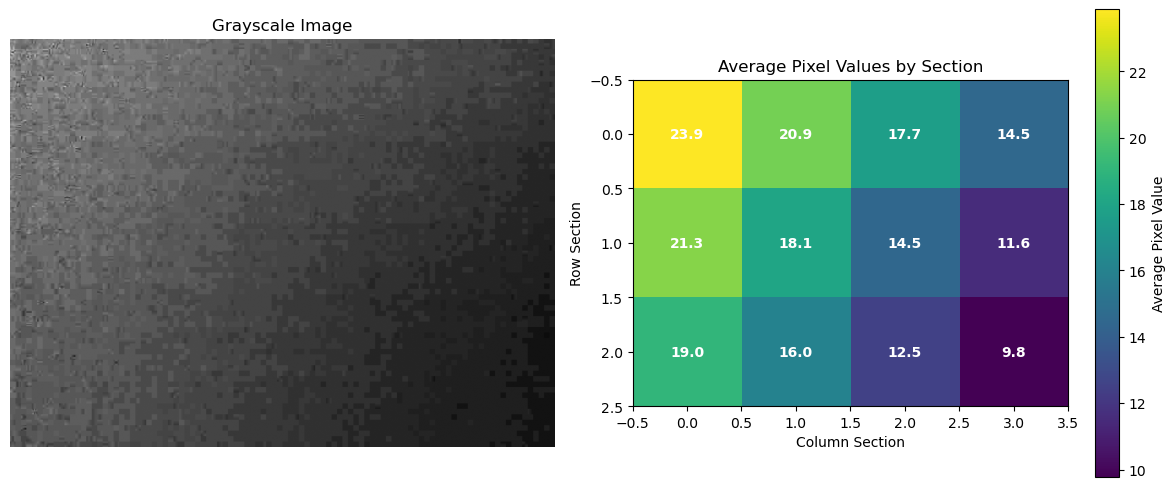

In [99]:
# Convert to grayscale for noise analysis
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

def pixel_average_analysis(gray, section_rows=3, section_cols=4, verbose=True):
    # Calculate overall average
    overall_avg = np.mean(gray)
    if verbose:
        print(f"Overall average pixel value: {overall_avg:.2f}")

    # Divide image into sections
    height, width = gray.shape
    section_rows = section_rows
    section_cols = section_cols

    row_size = height // section_rows
    col_size = width // section_cols

    if verbose:
        print(f"\nImage dimensions: {width} x {height}")
        print(f"Section size: {col_size} x {row_size}")
    # print("\nAverage pixel values by section:")

    # Create a matrix to store section averages
    section_averages = np.zeros((section_rows, section_cols))

    for i in range(section_rows):
        for j in range(section_cols):
            # Calculate section boundaries
            start_row = i * row_size
            end_row = (i + 1) * row_size if i < section_rows - 1 else height
            start_col = j * col_size
            end_col = (j + 1) * col_size if j < section_cols - 1 else width
            
            # Extract section
            section = gray[start_row:end_row, start_col:end_col]
            
            # Calculate average for this section
            section_avg = np.mean(section)
            section_averages[i, j] = section_avg
            
            # print(f"Section [{i+1},{j+1}]: {section_avg:.2f}")

    # Display statistics
    if verbose:
        print(f"\nNoise analysis:")
        print(f"Min section average: {np.min(section_averages):.2f}")
        print(f"Max section average: {np.max(section_averages):.2f}")
        print(f"Standard deviation across sections: {np.std(section_averages):.2f}")

    # Visualize the section averages as a heatmap
    if verbose:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(gray, cmap='gray')
        plt.title('Grayscale Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(section_averages, cmap='viridis', interpolation='nearest')
        plt.title('Average Pixel Values by Section')
        plt.colorbar(label='Average Pixel Value')
        plt.xlabel('Column Section')
        plt.ylabel('Row Section')

        # Add text annotations to show values
        for i in range(section_rows):
            for j in range(section_cols):
                plt.text(j, i, f'{section_averages[i,j]:.1f}', 
                        ha='center', va='center', color='white', fontweight='bold')

        plt.tight_layout()
        
        plt.show()

    return overall_avg, np.max(section_averages)

avgg, maxg = pixel_average_analysis(gray, section_rows=3, section_cols=4)


Image has background noise. Background will be subtracted from fluorescence image.

In [65]:
background_model = gray.copy().astype(np.float32)

def subtract_background(image, background):
    # Ensure both are float32 for proper subtraction
    img_float = image.astype(np.float32)
    bg_float = background.astype(np.float32)
    
    # Subtract background and clip to valid range
    result = np.clip(img_float - bg_float, 0, 255)
    return result.astype(np.uint8)

## 2. Image segmentation to focus on ROI

Overall average pixel value: 3.43

Image dimensions: 800 x 600
Section size: 200 x 200

Noise analysis:
Min section average: 0.98
Max section average: 12.94
Standard deviation across sections: 3.09


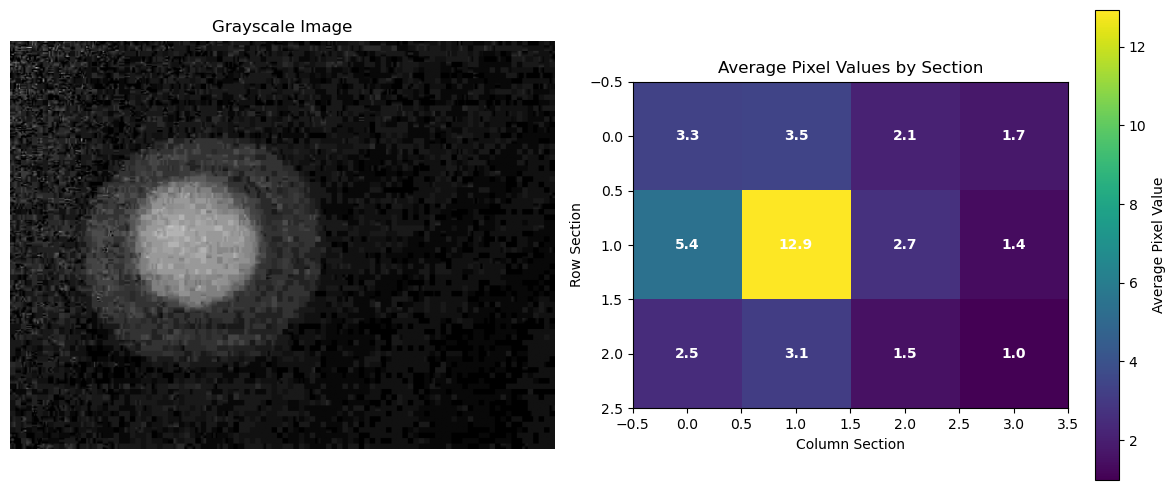

In [71]:
fluo = cv.imread('from-esp/image_20250628_135435_151.jpg')
fluog = cv.cvtColor(fluo, cv.COLOR_BGR2GRAY)

suback_fluog = subtract_background(fluog, background_model)
pixel_average_analysis(suback_fluog, section_rows=3, section_cols=4)

Found object with bounding box: x=163, y=192, width=213, height=205
Cropped ROI shape: (205, 213, 3)


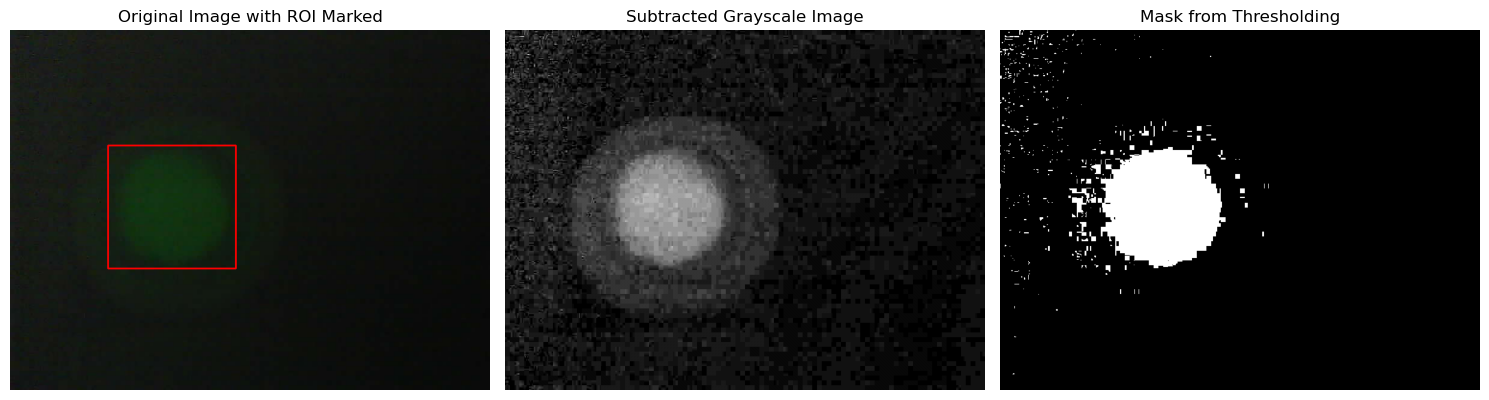

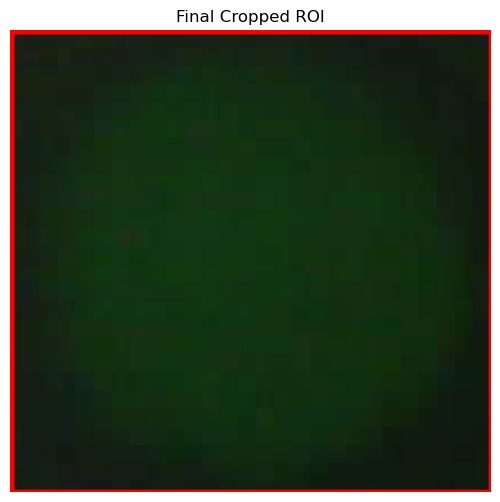

In [94]:
def get_cropped_roi(fluo, contours, mask):
    # Pixels brighter than 150 will become white (255), others black (0).
    threshold_value = 8
    _, mask = cv.threshold(suback_fluog, threshold_value, 255, cv.THRESH_BINARY)

    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    cropped_roi = None
    if contours:
        # Find the largest contour by area
        largest_contour = max(contours, key=cv.contourArea)

        # --- 5. Get the Bounding Box and Crop (Same as before) ---
        x, y, w, h = cv.boundingRect(largest_contour)

        # Draw a rectangle on the original image to show what was found
        cv.rectangle(fluo, (x, y), (x+w, y+h), (0, 0, 255), 2)

        # Crop the original image using the bounding box coordinates
        cropped_roi = fluo[y:y+h, x:x+w]
        print(f"Found object with bounding box: x={x}, y={y}, width={w}, height={h}")
        print(f"Cropped ROI shape: {cropped_roi.shape}")
    else:
        print("No object found meeting the threshold criteria.")


    # --- 6. Display the Results ---
    plt.figure(figsize=(15, 5))

    # Original image with ROI marked
    plt.subplot(1, 3, 1)
    plt.imshow(cv.cvtColor(fluo, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.title('Original Image with ROI Marked')
    plt.axis('off')

    # Grayscale image
    plt.subplot(1, 3, 2)
    plt.imshow(suback_fluog, cmap='gray')
    plt.title('Subtracted Grayscale Image')
    plt.axis('off')

    # Mask from thresholding
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask from Thresholding')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Display cropped ROI separately if it exists
    if cropped_roi is not None:
        plt.figure(figsize=(8, 6))
        plt.imshow(cv.cvtColor(cropped_roi, cv.COLOR_BGR2RGB))
        plt.title('Final Cropped ROI')
        plt.axis('off')
        plt.show()

    return cropped_roi, x, y, w, h

cropped_roi = get_cropped_roi(fluo, contours, mask)


Get segmented average pixel values

Overall average pixel value: 33.10

Image dimensions: 213 x 205
Section size: 53 x 51

Noise analysis:
Min section average: 25.95
Max section average: 38.21
Standard deviation across sections: 3.33


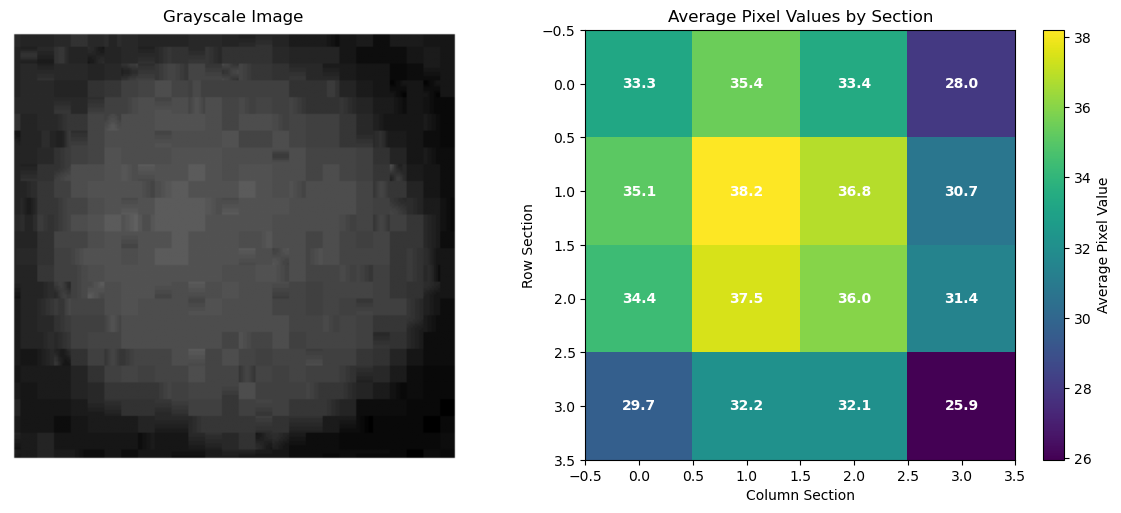

In [75]:
subgray_roi = cv.cvtColor(cropped_roi, cv.COLOR_BGR2GRAY)
pixel_average_analysis(subgray_roi, section_rows=4, section_cols=4)

## 3. Test on all fluorescent images (no cropping)

Check first image

Overall average pixel value: 6.59

Image dimensions: 800 x 600
Section size: 100 x 100

Noise analysis:
Min section average: 0.69
Max section average: 64.05
Standard deviation across sections: 12.19


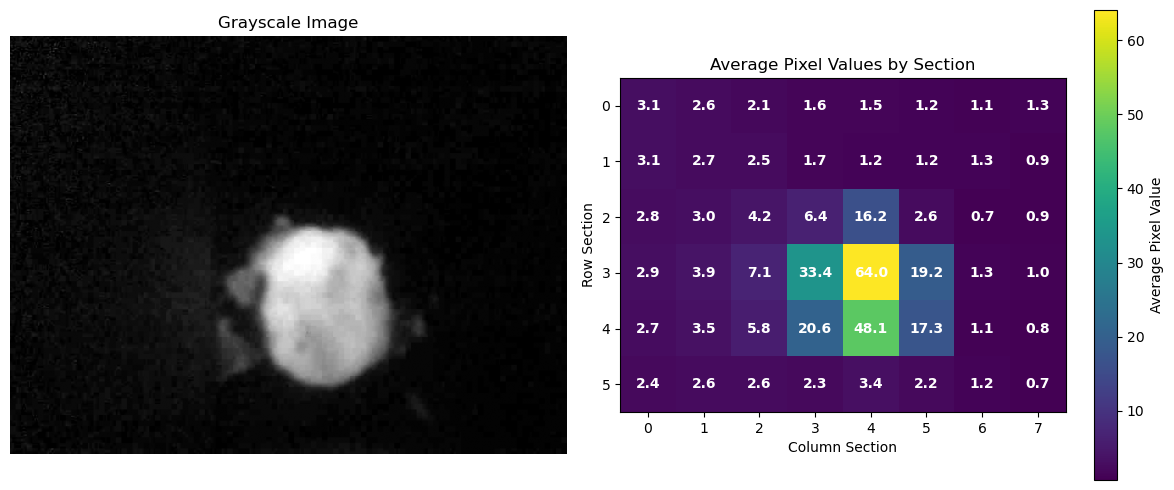

In [93]:
fluo1 = cv.imread('from-esp/image_0001.jpg')
fluo1g = cv.cvtColor(fluo1, cv.COLOR_BGR2GRAY)
suback_fluog1 = subtract_background(fluo1g, background_model)
avg1g, max1g = pixel_average_analysis(suback_fluog1, section_rows=6, section_cols=8)

In [91]:
print(f"Average: {avg1g} \nMax: {max1g}")

Average: 6.58763125 
Max: 40.81603333333333


Use on last image

Overall average pixel value: 3.48

Image dimensions: 800 x 600
Section size: 100 x 100

Noise analysis:
Min section average: 1.95
Max section average: 8.07
Standard deviation across sections: 1.17


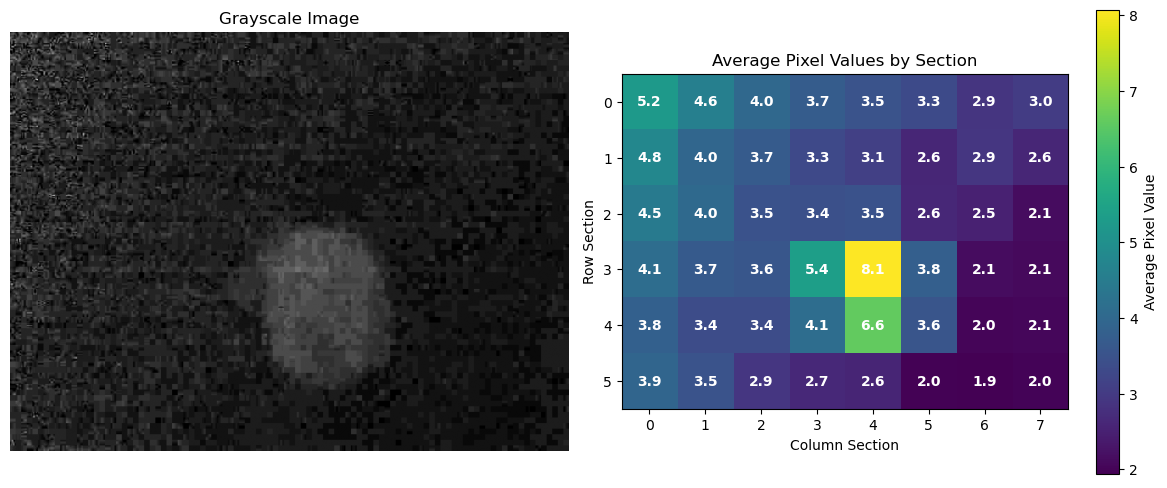

In [95]:
fluo48 = cv.imread('from-esp/image_0048.jpg')
fluo48g = cv.cvtColor(fluo48, cv.COLOR_BGR2GRAY)
suback_fluog48 = subtract_background(fluo48g, background_model)
avg48g, max48g = pixel_average_analysis(suback_fluog48, section_rows=6, section_cols=8)

Perform on all images

In [102]:
max_list = np.zeros(48)

for i in range(1, 49):
    fluo = cv.imread(f'from-esp/image_{i:04d}.jpg')
    fluo_g = cv.cvtColor(fluo, cv.COLOR_BGR2GRAY)
    suback_fluog = subtract_background(fluo_g, background_model)
    avg, max_val = pixel_average_analysis(suback_fluog, section_rows=6, section_cols=8, verbose=False)
    print(f"Image {i}: Average: {avg:.2f}, Max: {max_val:.2f}")
    
    max_list[i-1] = max_val

Image 1: Average: 6.59, Max: 64.05
Image 2: Average: 6.41, Max: 62.12
Image 3: Average: 6.10, Max: 59.44
Image 4: Average: 5.32, Max: 50.68
Image 5: Average: 4.90, Max: 43.66
Image 6: Average: 4.74, Max: 38.93
Image 7: Average: 4.49, Max: 35.11
Image 8: Average: 4.36, Max: 32.11
Image 9: Average: 4.16, Max: 29.36
Image 10: Average: 4.09, Max: 27.22
Image 11: Average: 3.85, Max: 25.12
Image 12: Average: 3.86, Max: 23.45
Image 13: Average: 3.77, Max: 22.04
Image 14: Average: 3.81, Max: 20.86
Image 15: Average: 3.75, Max: 19.61
Image 16: Average: 3.62, Max: 18.69
Image 17: Average: 3.60, Max: 17.90
Image 18: Average: 3.57, Max: 16.85
Image 19: Average: 3.68, Max: 16.36
Image 20: Average: 3.61, Max: 15.70
Image 21: Average: 3.58, Max: 14.86
Image 22: Average: 3.66, Max: 14.56
Image 23: Average: 3.64, Max: 14.10
Image 24: Average: 3.51, Max: 13.50
Image 25: Average: 3.63, Max: 13.33
Image 26: Average: 3.55, Max: 12.77
Image 27: Average: 3.56, Max: 12.40
Image 28: Average: 3.58, Max: 12.05
I

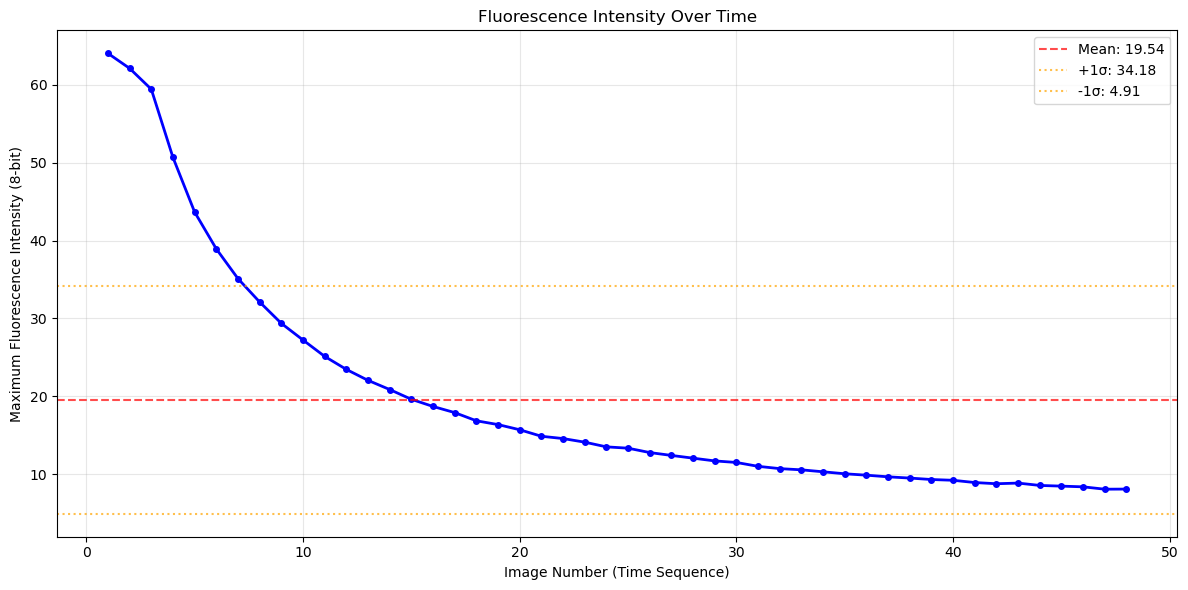


Fluorescence Intensity Statistics:
Mean: 19.54
Standard Deviation: 14.63
Min: 8.06
Max: 64.05
Range: 55.99


In [103]:
# Create the fluorescence intensity graph
plt.figure(figsize=(12, 6))

# Create time axis (image numbers)
image_numbers = list(range(1, len(max_list) + 1))

# Plot the max fluorescence values
plt.plot(image_numbers, max_list, 'b-o', linewidth=2, markersize=4)
plt.xlabel('Image Number (Time Sequence)')
plt.ylabel('Maximum Fluorescence Intensity (8-bit)')
plt.title('Fluorescence Intensity Over Time')
plt.grid(True, alpha=0.3)

# Add some statistics
mean_intensity = np.mean(max_list)
std_intensity = np.std(max_list)
plt.axhline(y=mean_intensity, color='r', linestyle='--', alpha=0.7, label=f'Mean: {mean_intensity:.2f}')
plt.axhline(y=mean_intensity + std_intensity, color='orange', linestyle=':', alpha=0.7, label=f'+1σ: {mean_intensity + std_intensity:.2f}')
plt.axhline(y=mean_intensity - std_intensity, color='orange', linestyle=':', alpha=0.7, label=f'-1σ: {mean_intensity - std_intensity:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nFluorescence Intensity Statistics:")
print(f"Mean: {mean_intensity:.2f}")
print(f"Standard Deviation: {std_intensity:.2f}")
print(f"Min: {min(max_list):.2f}")
print(f"Max: {max(max_list):.2f}")
print(f"Range: {max(max_list) - min(max_list):.2f}")